# Plotting up the statistical output

To gain an understanding of the meaning of the statistics, and the spatial distribution of these statistics, we  plot up several of the metrics on maps. This allows you to explore how these variables vary over the simulation domain, and interpret the meaning of these variables. 

This only gives one perspective on the choice of variables used in TCRM to simulate TC track behaviour. There are a number of other graphical products that further help with understanding the way TCRM works.

In [2]:
%matplotlib inline
import os
import io
import sys

from Utilities.config import ConfigParser
from Utilities.nctools import ncLoadFile, ncGetDims, ncGetVar, ncFileInfo
from Utilities.grid import SampleGrid
from PlotInterface.maps import ArrayMapFigure, saveFigure, levels
import numpy as np
from IPython.display import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FC

from os.path import join as pjoin
import seaborn as sns
sns.set_context('paper')

Use the normal approach of setting up a configuration string, and set it up to read data from the output folders containing the data we've generated in previous notebooks.

In [3]:
configstr = """
[DataProcess]
InputFile=C:/WorkSpace/data/TC/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=False

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':90.,'xMax':180.,'yMin':-30.0,'yMax':-5.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=5000
YearsPerSimulation=10
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = C:/WorkSpace/tcrm/input/landmask.nc
mslpfile = C:/WorkSpace/tcrm/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=C:/WorkSpace/data/TC/aus

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=C:/WorkSpace/data/TC/aus/log/aus.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r09.csv.gz
path = C:/WorkSpace/data/TC/
filename = Allstorms.ibtracs_wmo.v03r09.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = C:/WorkSpace/data/MSLP
filename = slp.day.ltm.nc
"""

config = ConfigParser()
config.readfp(io.BytesIO(configstr))

In [5]:
landmask_file = config.get('Input', 'Landmask')
landmask = SampleGrid(landmask_file)

In [2]:
def show(fig):
    canvas = FC(fig)
    fig

One thing that we realise in the statistics is that TC behaviour changes when a TC makes landfall. And because the number of observations in any given cell may not be sufficient to calculate reliable statistics, TCRM automatically increases the region that is sampled. 

This causes problems in regions close to land. If the model is determining statistics for one of these cells close to the coast (but offshore), and the expanded region starts capturing observations from over land, then the statistics are not truly representative of behaviour of offshore TCs. This is important for parameters related to intensity - TCs can often continue intensifying right up to landfall. But if we are sampling statistics of TCs overland, then we dilute the intensity statistics with observations from overland which (nearly without exception) act to weaken the storm.

To avoid any potential issues like this, TCRM flags over-land observations, and the statistics are calculated separately for over-water and over-land observations. When it comes to viewing the results, we need to read in the over-water and over-land observations separately, then combine them into a single grid for plotting. This next function does exactly that. 

In [6]:
def getData(ncobj, varname, ij):
    var = ncGetVar(ncobj, varname)[:]
    lvar = ncGetVar(ncobj, 'l'+varname)[:]
    data = var
    data[ij] = lvar[ij]
    return data

Let's breifly look at the statistical data generated. Here, we load the 'pressure_rate_stats.nc' file, which contains the statistics for the pressure rate of change (hPa/hr) of obsersved TCs. 

In [ ]:
outputPath = config.get("Output", "Path")
processPath = pjoin(outputPath, "process")
fname = pjoin(processPath, "pressure_rate_stats.nc")

There's a convenience function in the `nctools` moudule called `ncFileInfo`, which prints out some basic attributes of the file, including the list of variables. You can also provide a `variable` argument, and it will print out the attributes of the variable.

In [7]:
ncFileInfo(fname)

<type 'netCDF4.Dataset'>
root group (NETCDF4 file format):
    created_on: 2017-08-19 20:55:34
    created_by: u12161
    Conventions: CF-1.6
    dimensions: lat, lon
    variables: lat, lon, mu, alpha, sig, min, lmu, lalpha, lsig, lmin, cell, phi, lphi
    groups: 



The first two variables are the dimension variables, `lat` and `lon`. 

In [37]:
ncFileInfo(fname, variable='lat')

<type 'netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    long_name: Latitude
unlimited dimensions: 
current shape = (30,)



In [38]:
ncFileInfo(fname, variable='lon')

<type 'netCDF4.Variable'>
float32 lon(lon)
    units: degrees_east
    long_name: Longitude
unlimited dimensions: 
current shape = (119,)



Now we'll look at the variables. Start with the simplest one, `mu` and `lmu`. 

In [36]:
ncFileInfo(fname, variable='mu')

<type 'netCDF4.Variable'>
float32 mu(lat, lon)
    _FillValue: 2.14748e+09
    units: m/s
    long_name: Mean pressure_rate
unlimited dimensions: 
current shape = (30, 119)



In [35]:
ncFileInfo(fname, variable='lmu')

<type 'netCDF4.Variable'>
float32 lmu(lat, lon)
    _FillValue: 2.14748e+09
    units: m/s
    long_name: Mean pressure_rate (over land)
unlimited dimensions: 
current shape = (30, 119)



Simply, the `l` prefix indicates that the variable has been calculated only from over-land observations. 

In [8]:
ncobj = ncLoadFile(fname)

lon = ncGetDims(ncobj, 'lon')
lat = ncGetDims(ncobj, 'lat')
ncobj.close()
xgrid, ygrid = np.meshgrid(lon, lat)

ls = np.zeros(np.shape(xgrid))

for i in range(len(lon)):
    for j in range(len(lat)):
        if landmask.sampleGrid(lon[i], lat[j]) > 0.0:
            ls[j, i] = 1
            
ij = np.where(ls==1)


Set the map keyword arguments that will help draw the basemap. 

In [9]:
map_kwargs = dict(llcrnrlon=100., llcrnrlat=-30,
                  urcrnrlon=160., urcrnrlat=-5.,
                  resolution='h', projection='merc')

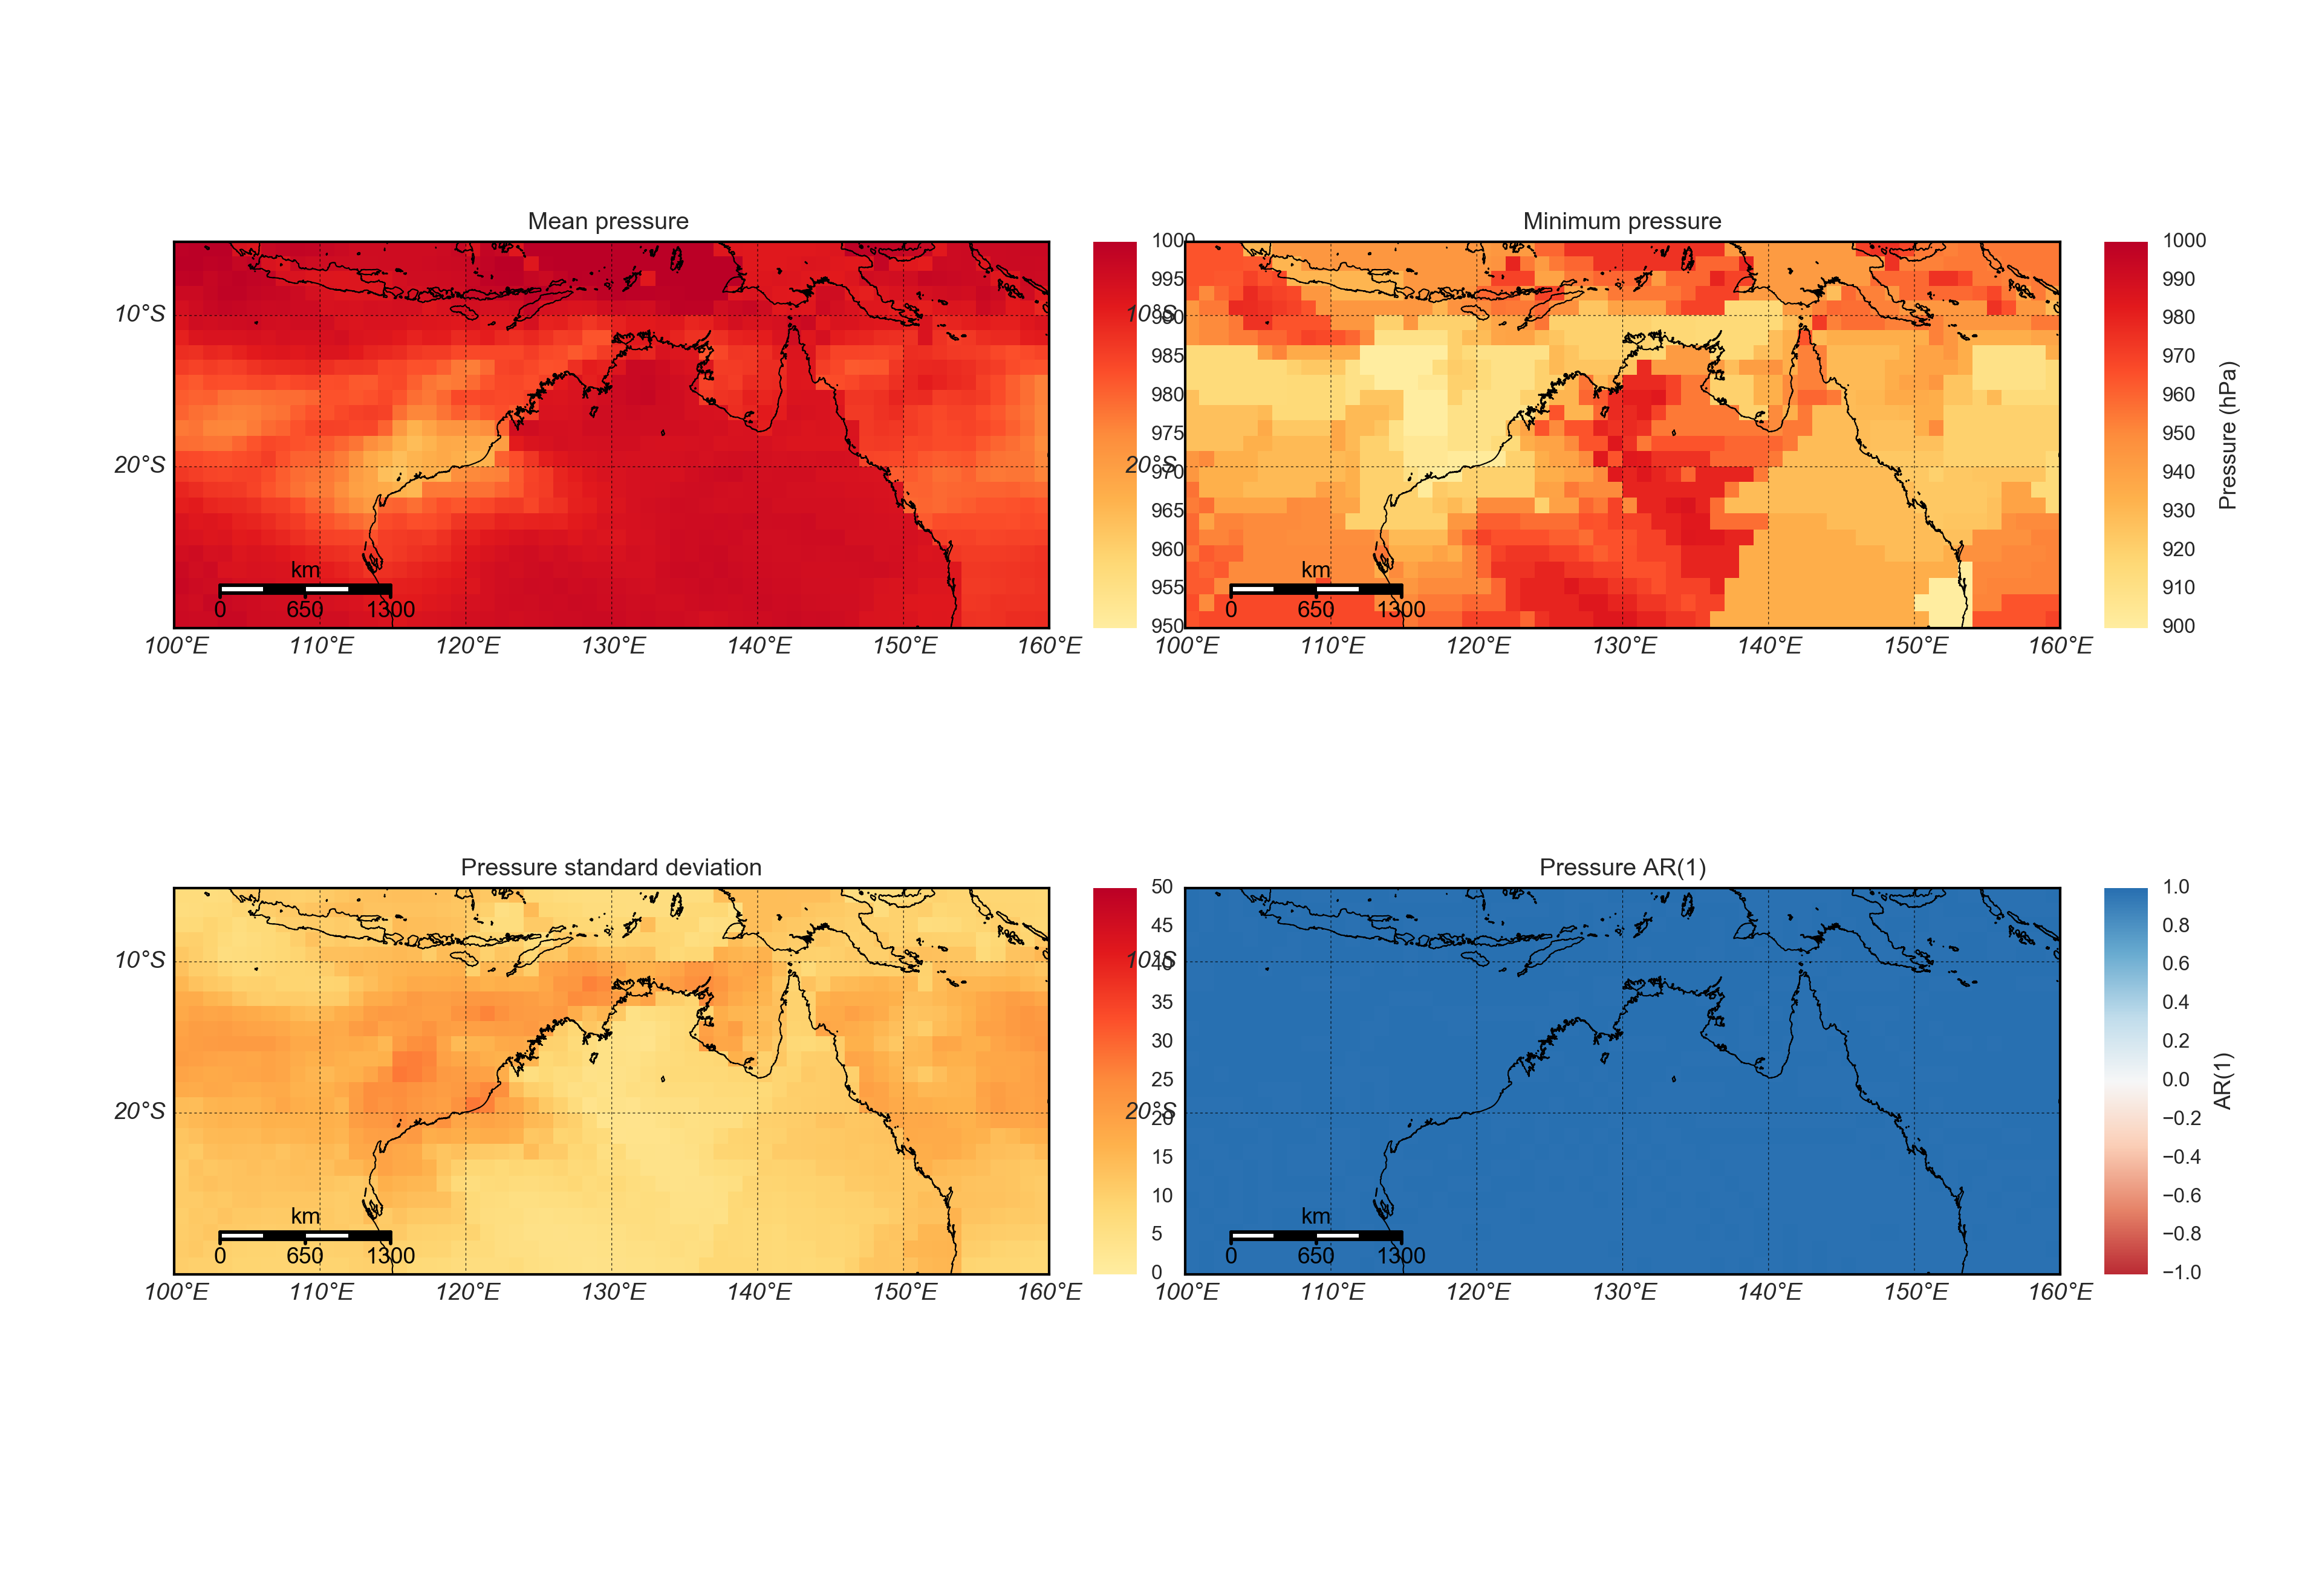

In [15]:
ncobj = ncLoadFile(pjoin(processPath, "pressure_stats.nc"))
lon = ncGetDims(ncobj, 'lon')
lat = ncGetDims(ncobj, 'lat')
ardata = getData(ncobj, 'alpha', ij)
mudata = getData(ncobj, 'mu', ij)
mindata = getData(ncobj, 'min', ij)
sigdata = getData(ncobj, 'sig', ij)
ncobj.close()
fig = ArrayMapFigure()
fig.add(mudata, xgrid, ygrid, 'Mean pressure ', [950, 1000], 'Pressure (hPa)', map_kwargs)
fig.add(mindata, xgrid, ygrid, 'Minimum pressure', [900, 1000], 'Pressure (hPa)', map_kwargs)
fig.add(sigdata, xgrid, ygrid, 'Pressure standard deviation', [0, 50], 'Std dev.', map_kwargs)
fig.add(ardata, xgrid, ygrid, 'Pressure AR(1)', [-1, 1], 'AR(1)', map_kwargs)
fig.plot()
saveFigure(fig, "pressure_stats.png")
Image("pressure_stats.png")

The first figure shows the mean pressure (in hPa) in each cell across the simulation domain. It's important to recognise that in areas with few observations, the mean may not be well-defined. TCRM makes an effort to address this, by expanding the sampling region if there are insufficient observations in an individual cell. 

Next is the minimum pressure. This is where we can see some significant variability, because the minimum pressure in any given cell depends on the vagaries of historical TC behaviour, and we are looking at an extreme value in the distribution of pressure values in each cell. 

The third figure is the standard deviation of the pressure observations. Areas where there's a lot of variation are likely near coastlines and at the outer limits of the simulation region, where TC intensity is more variable.

The final figure shows the lag-1 autocorrelation of pressure observations. For this variable, the values are all very close to 1, because the pressure values do not change dramatically from one observation to the next. For example, the largest change in pressure over a 6-hour period is only about *XX* hPa - compare that to the pressure observation and the change is (in a numerical sense) quite small. But this is not the case for all the model variables, as we will see below.

Now lets examine the pressure rate statistics. This is measuring the intensification rate of TCs in each cell, rather than the intensity (above). 

The first figure is the mean pressure rate of change. Positive values indicate an increase in pressure, negative values a decrease in pressure. This shows us the (historically) favoured regions for intensification and weakening of TCs. 

In figure 4 is the lag-1 autocorrelation. Compare the values plotted here with the corresponding figure for the pressure variable (above). We saw previously that the pressure rate of change is largely uncorrelated when looking at the autocorrelation. But what spatial patterns emerge in the pressure rate statistics? 

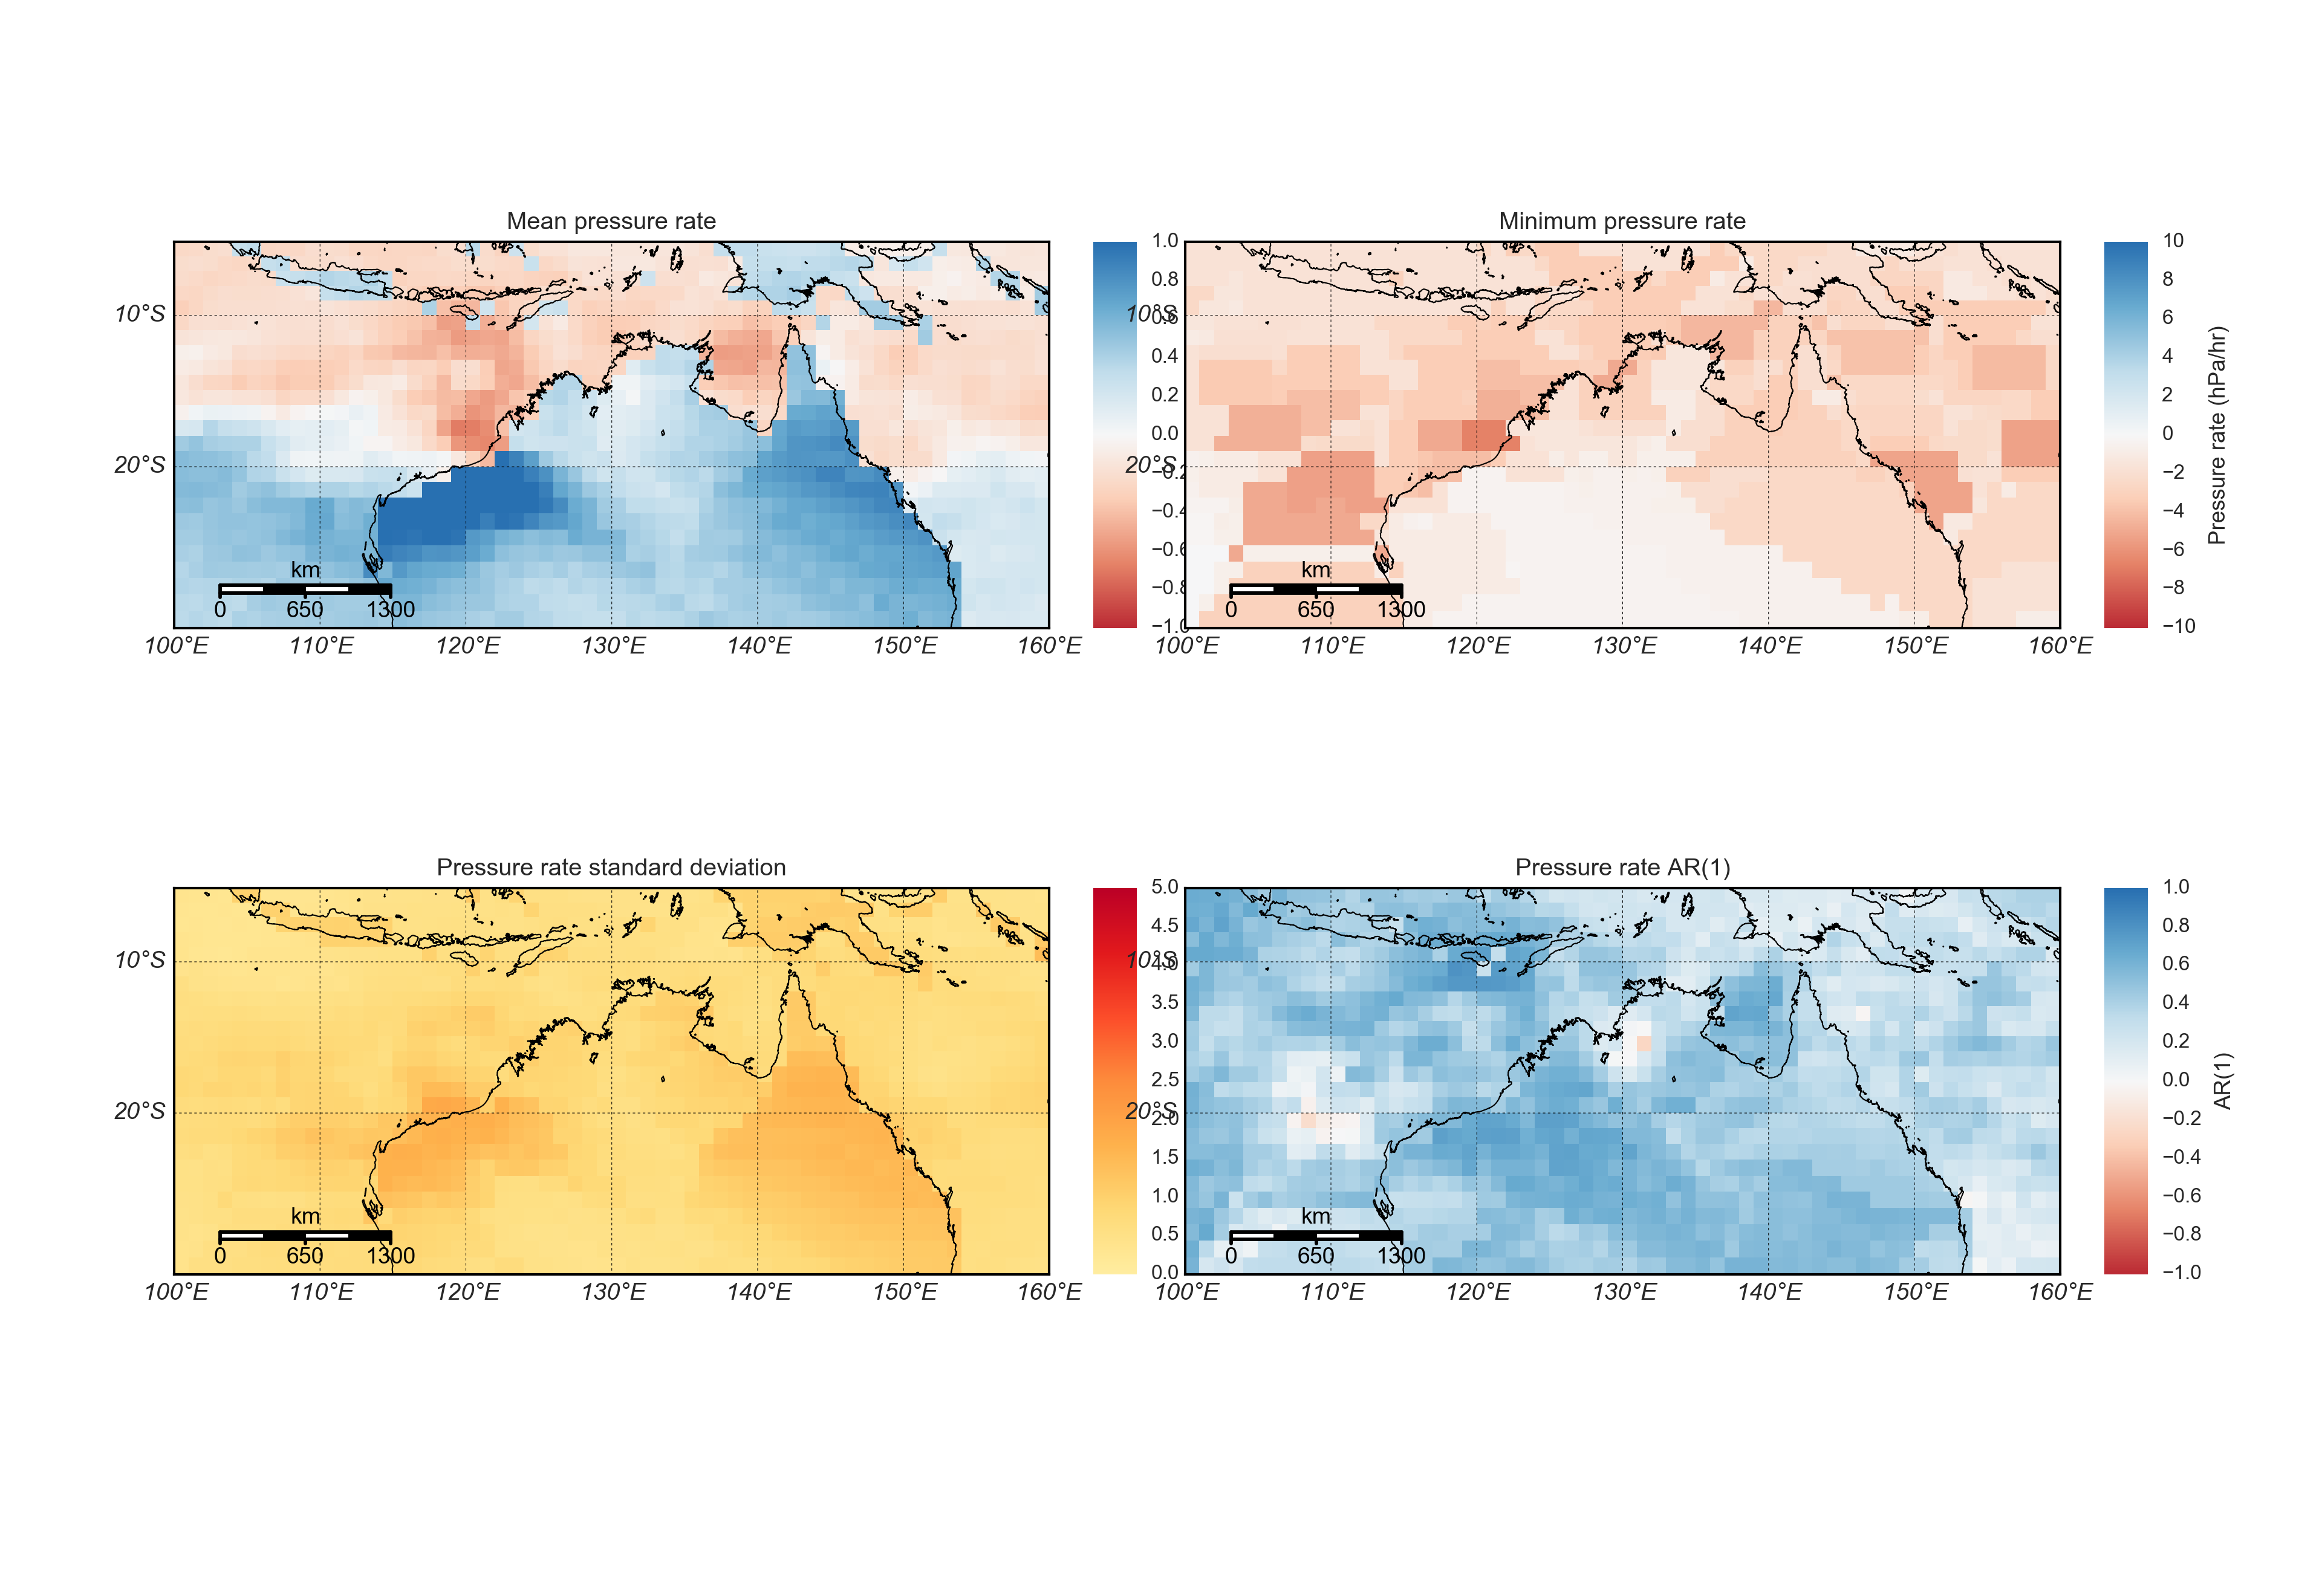

In [17]:
ncobj = ncLoadFile(pjoin(processPath, "pressure_rate_stats.nc"))
lon = ncGetDims(ncobj, 'lon')
lat = ncGetDims(ncobj, 'lat')
ardata = getData(ncobj, 'alpha', ij)
mudata = getData(ncobj, 'mu', ij)
mindata = getData(ncobj, 'min', ij)
sigdata = getData(ncobj, 'sig', ij)
ncobj.close()

fig = ArrayMapFigure()
fig.add(mudata, xgrid, ygrid, 'Mean pressure rate', [-1, 1], 'Pressure rate (hPa/hr)', map_kwargs)
fig.add(mindata, xgrid, ygrid, 'Minimum pressure rate', [-10, 10], 'Pressure rate (hPa/hr)', map_kwargs)
fig.add(sigdata, xgrid, ygrid, 'Pressure rate standard deviation', [0, 5], 'Std dev.', map_kwargs)
fig.add(ardata, xgrid, ygrid, 'Pressure rate AR(1)', [-1, 1], 'AR(1)', map_kwargs)
fig.plot()

saveFigure(fig, "pressure_rate_stats.png")
Image("pressure_rate_stats.png")

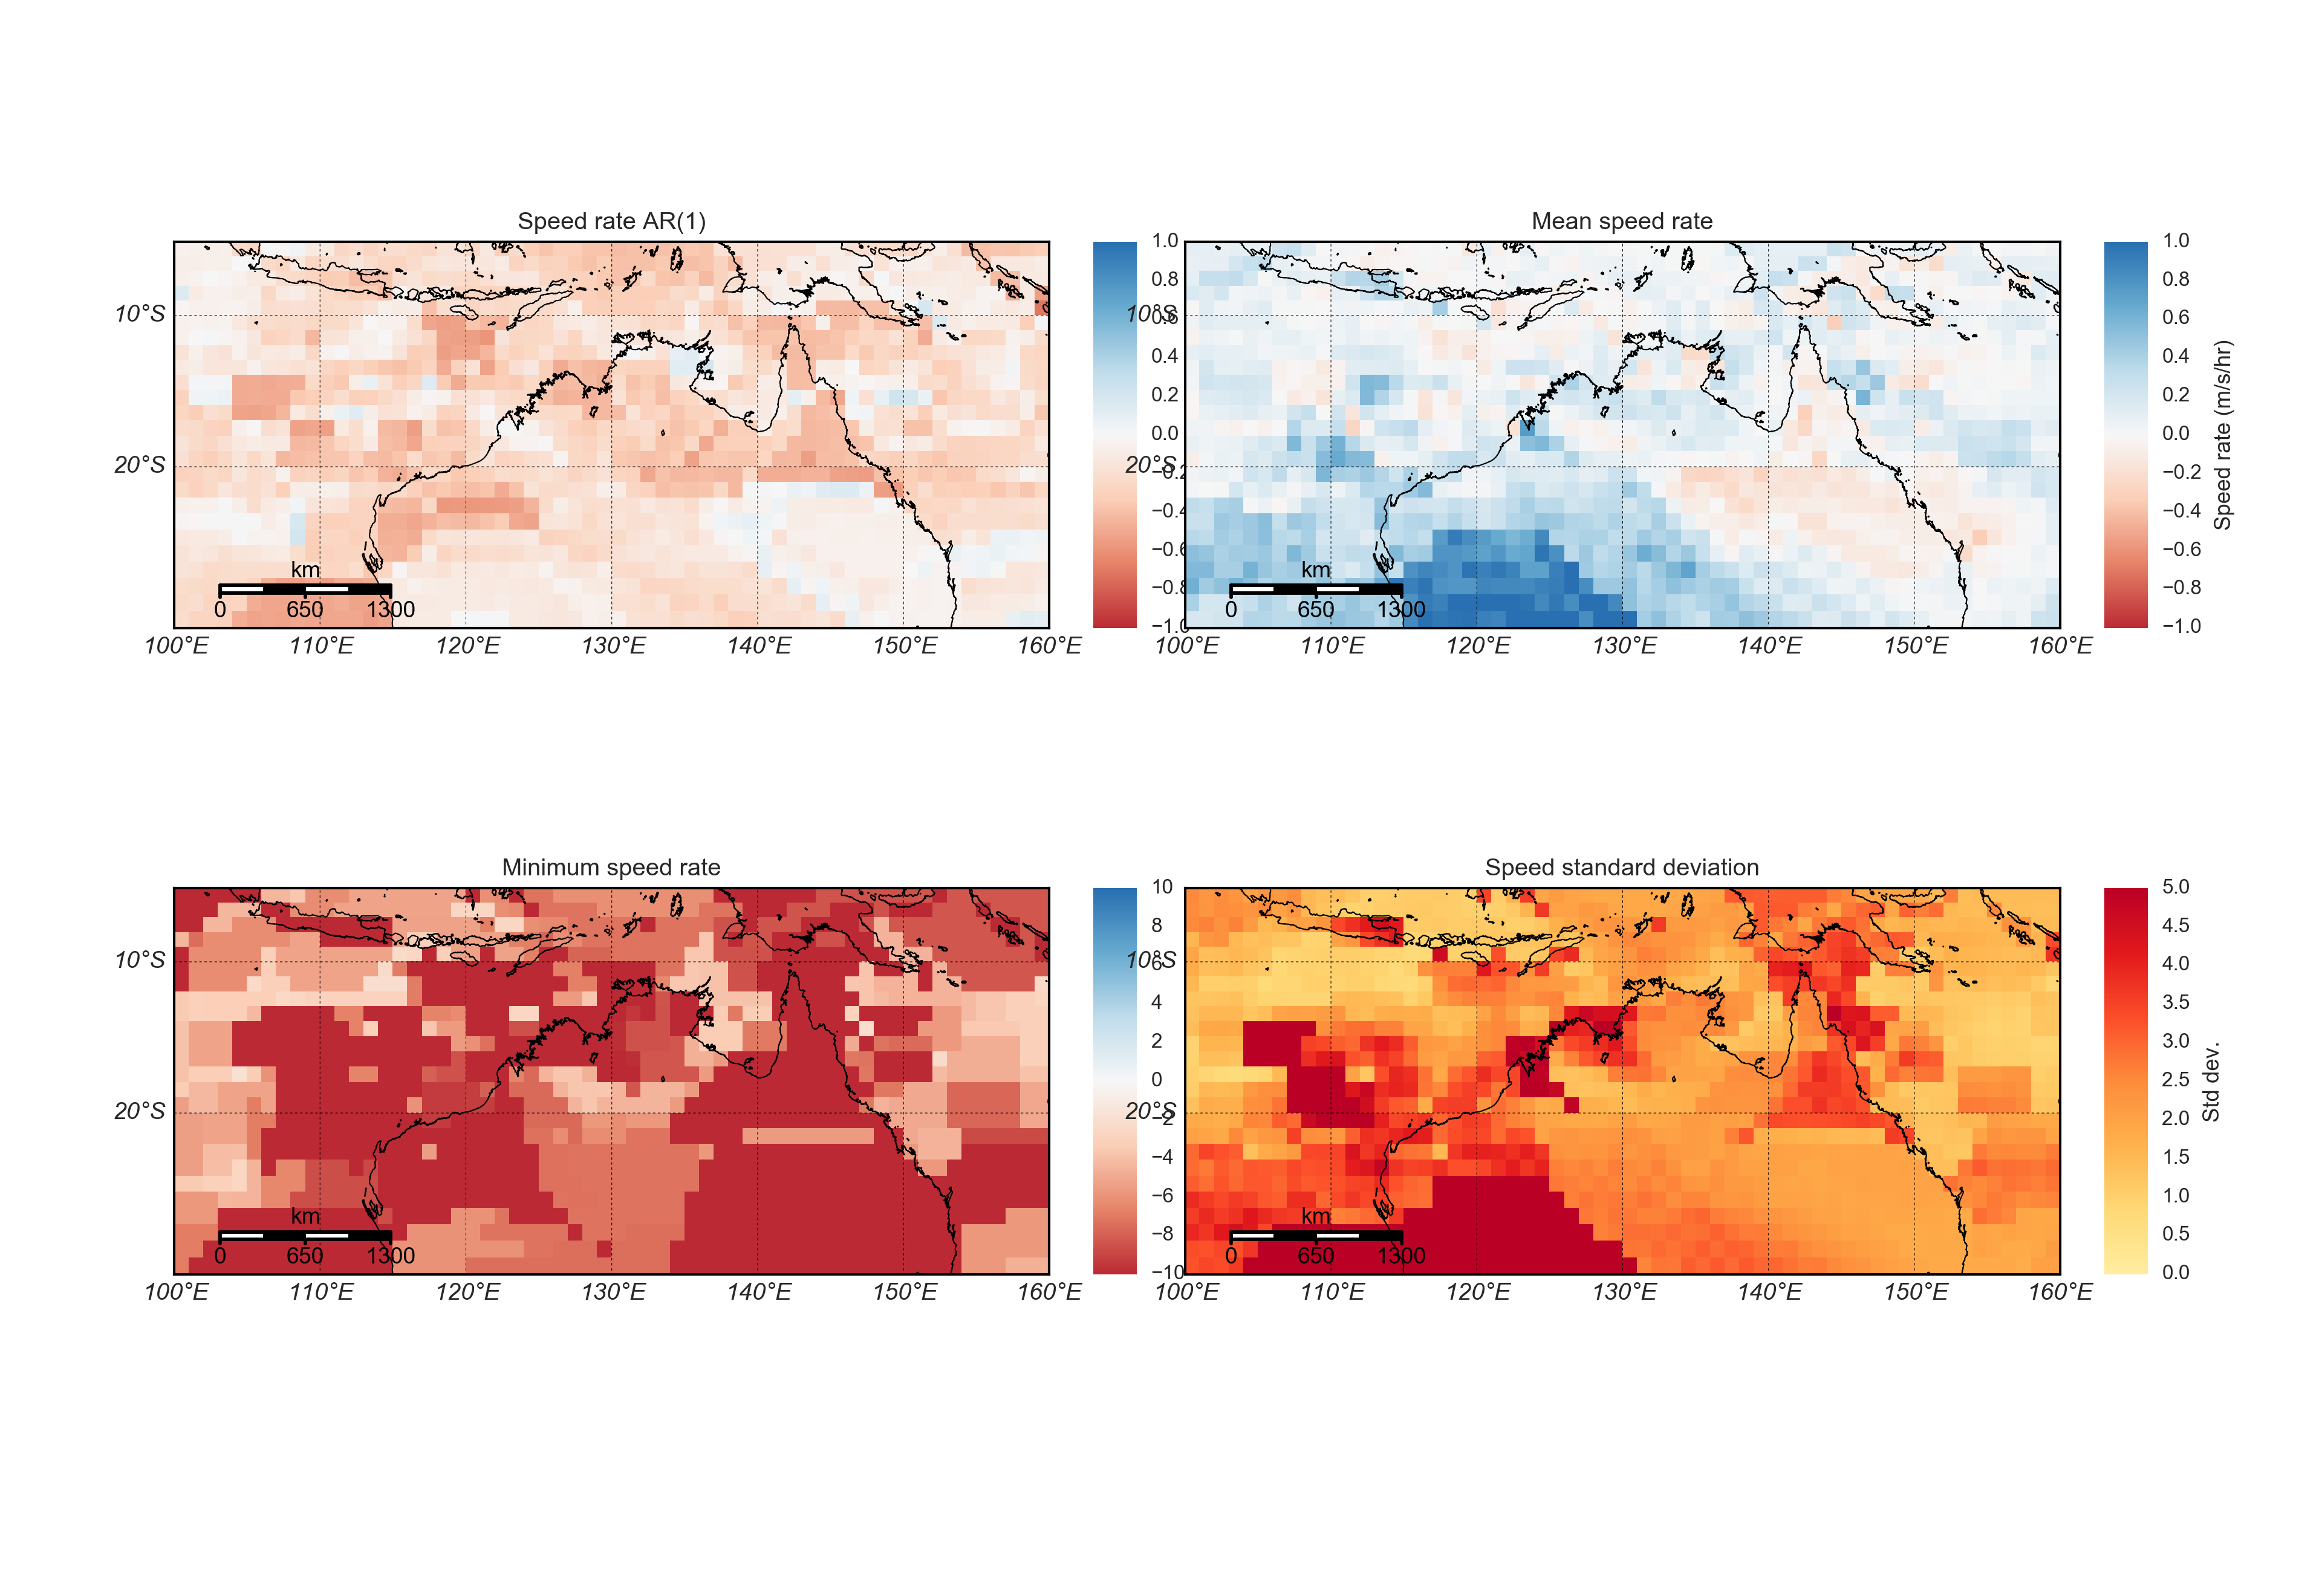

In [18]:
ncobj = ncLoadFile(pjoin(processPath, "speed_rate_stats.nc"))
lon = ncGetDims(ncobj, 'lon')
lat = ncGetDims(ncobj, 'lat')
ardata = getData(ncobj, 'alpha', ij)
mudata = getData(ncobj, 'mu', ij)
mindata = getData(ncobj, 'min', ij)
sigdata = getData(ncobj, 'sig', ij)
ncobj.close()
fig = ArrayMapFigure()
fig.add(ardata, xgrid, ygrid, 'Speed rate AR(1)', [-1, 1], 'AR(1)', map_kwargs)
fig.add(mudata, xgrid, ygrid, 'Mean speed rate', [-1, 1], 'Speed rate (m/s/hr)', map_kwargs)
fig.add(mindata, xgrid, ygrid, 'Minimum speed rate', [-10, 10], 'Speed rate (m/s/hr)', map_kwargs)
fig.add(sigdata, xgrid, ygrid, 'Speed standard deviation', [0, 5], 'Std dev.', map_kwargs)
fig.plot()
#canvas = FC(fig)
#fig
saveFigure(fig, "speed_rate_stats.png")
Image("speed_rate_stats.png")

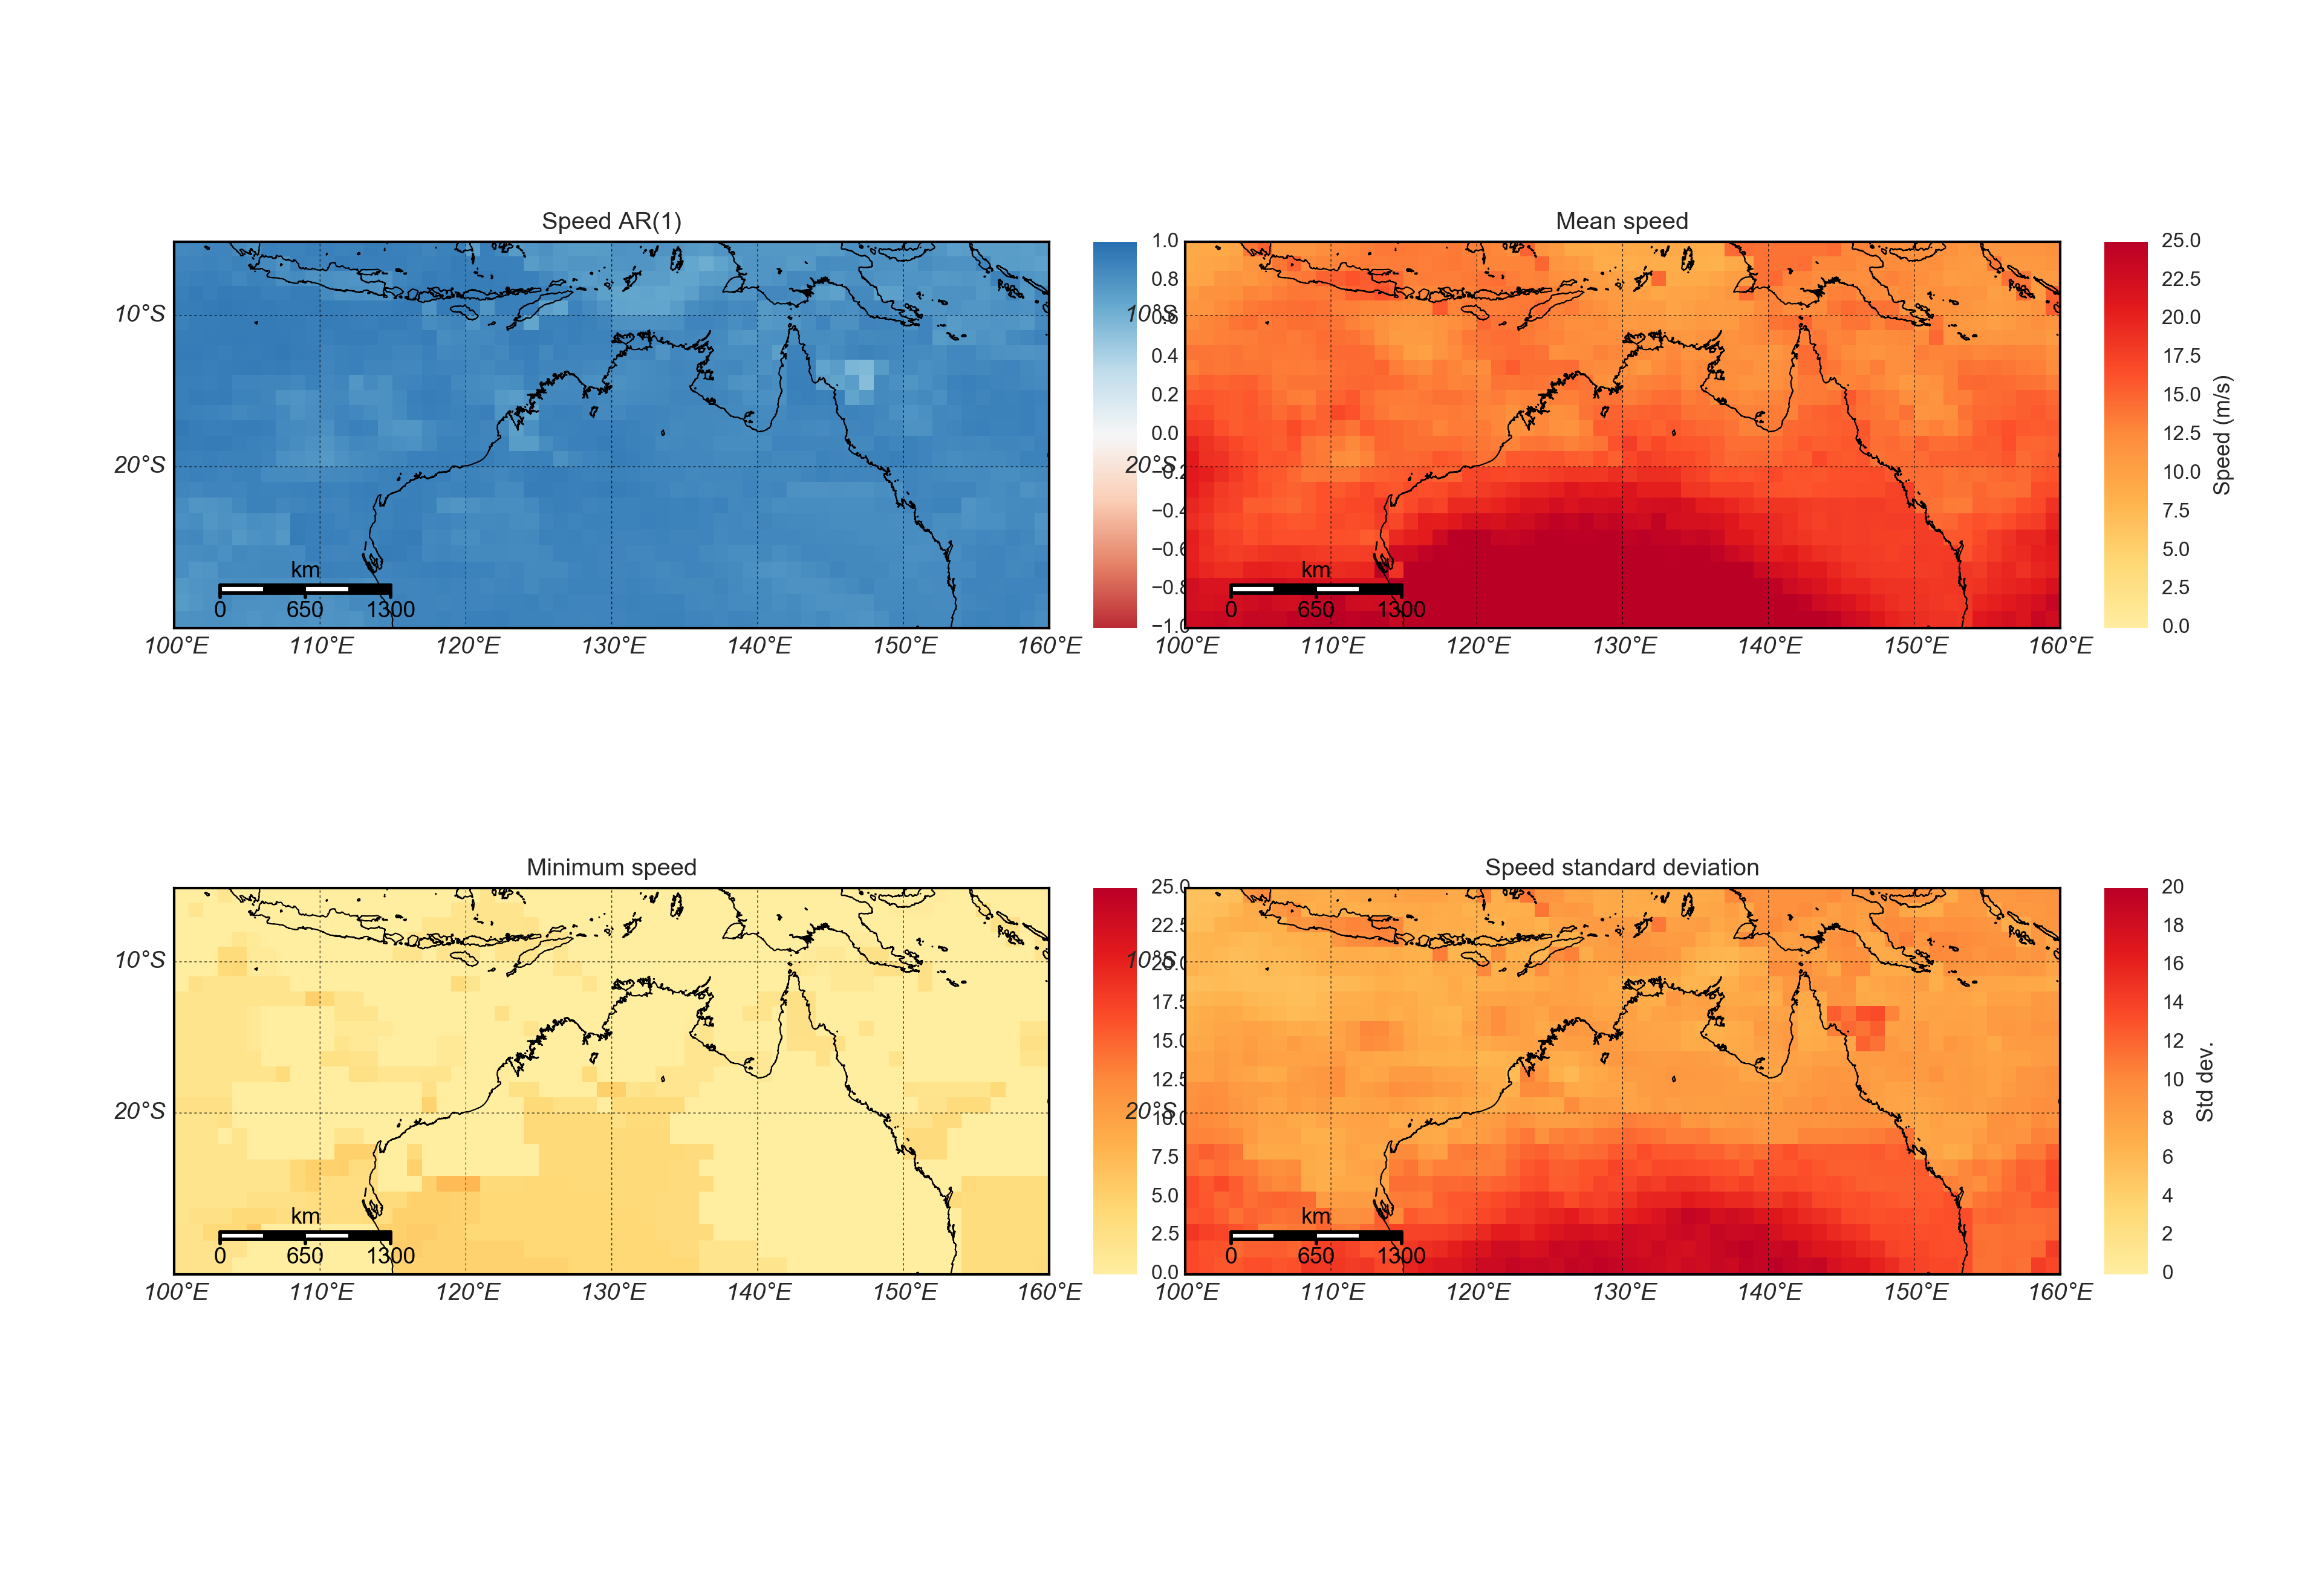

In [19]:
ncobj = ncLoadFile(pjoin(processPath, "speed_stats.nc"))
lon = ncGetDims(ncobj, 'lon')
lat = ncGetDims(ncobj, 'lat')
ardata = getData(ncobj, 'alpha', ij)
mudata = getData(ncobj, 'mu', ij)
mindata = getData(ncobj, 'min', ij)
sigdata = getData(ncobj, 'sig', ij)
ncobj.close()
fig = ArrayMapFigure()
fig.add(ardata, xgrid, ygrid, 'Speed AR(1)', [-1, 1], 'AR(1)', map_kwargs)
fig.add(mudata, xgrid, ygrid, 'Mean speed', [0, 25], 'Speed (m/s)', map_kwargs)
fig.add(mindata, xgrid, ygrid, 'Minimum speed', [0, 25], 'Speed (m/s)', map_kwargs)
fig.add(sigdata, xgrid, ygrid, 'Speed standard deviation', [0, 20], 'Std dev.', map_kwargs)
fig.plot()
#canvas = FC(fig)
#fig
saveFigure(fig, "speed_stats.png")
Image("speed_stats.png")

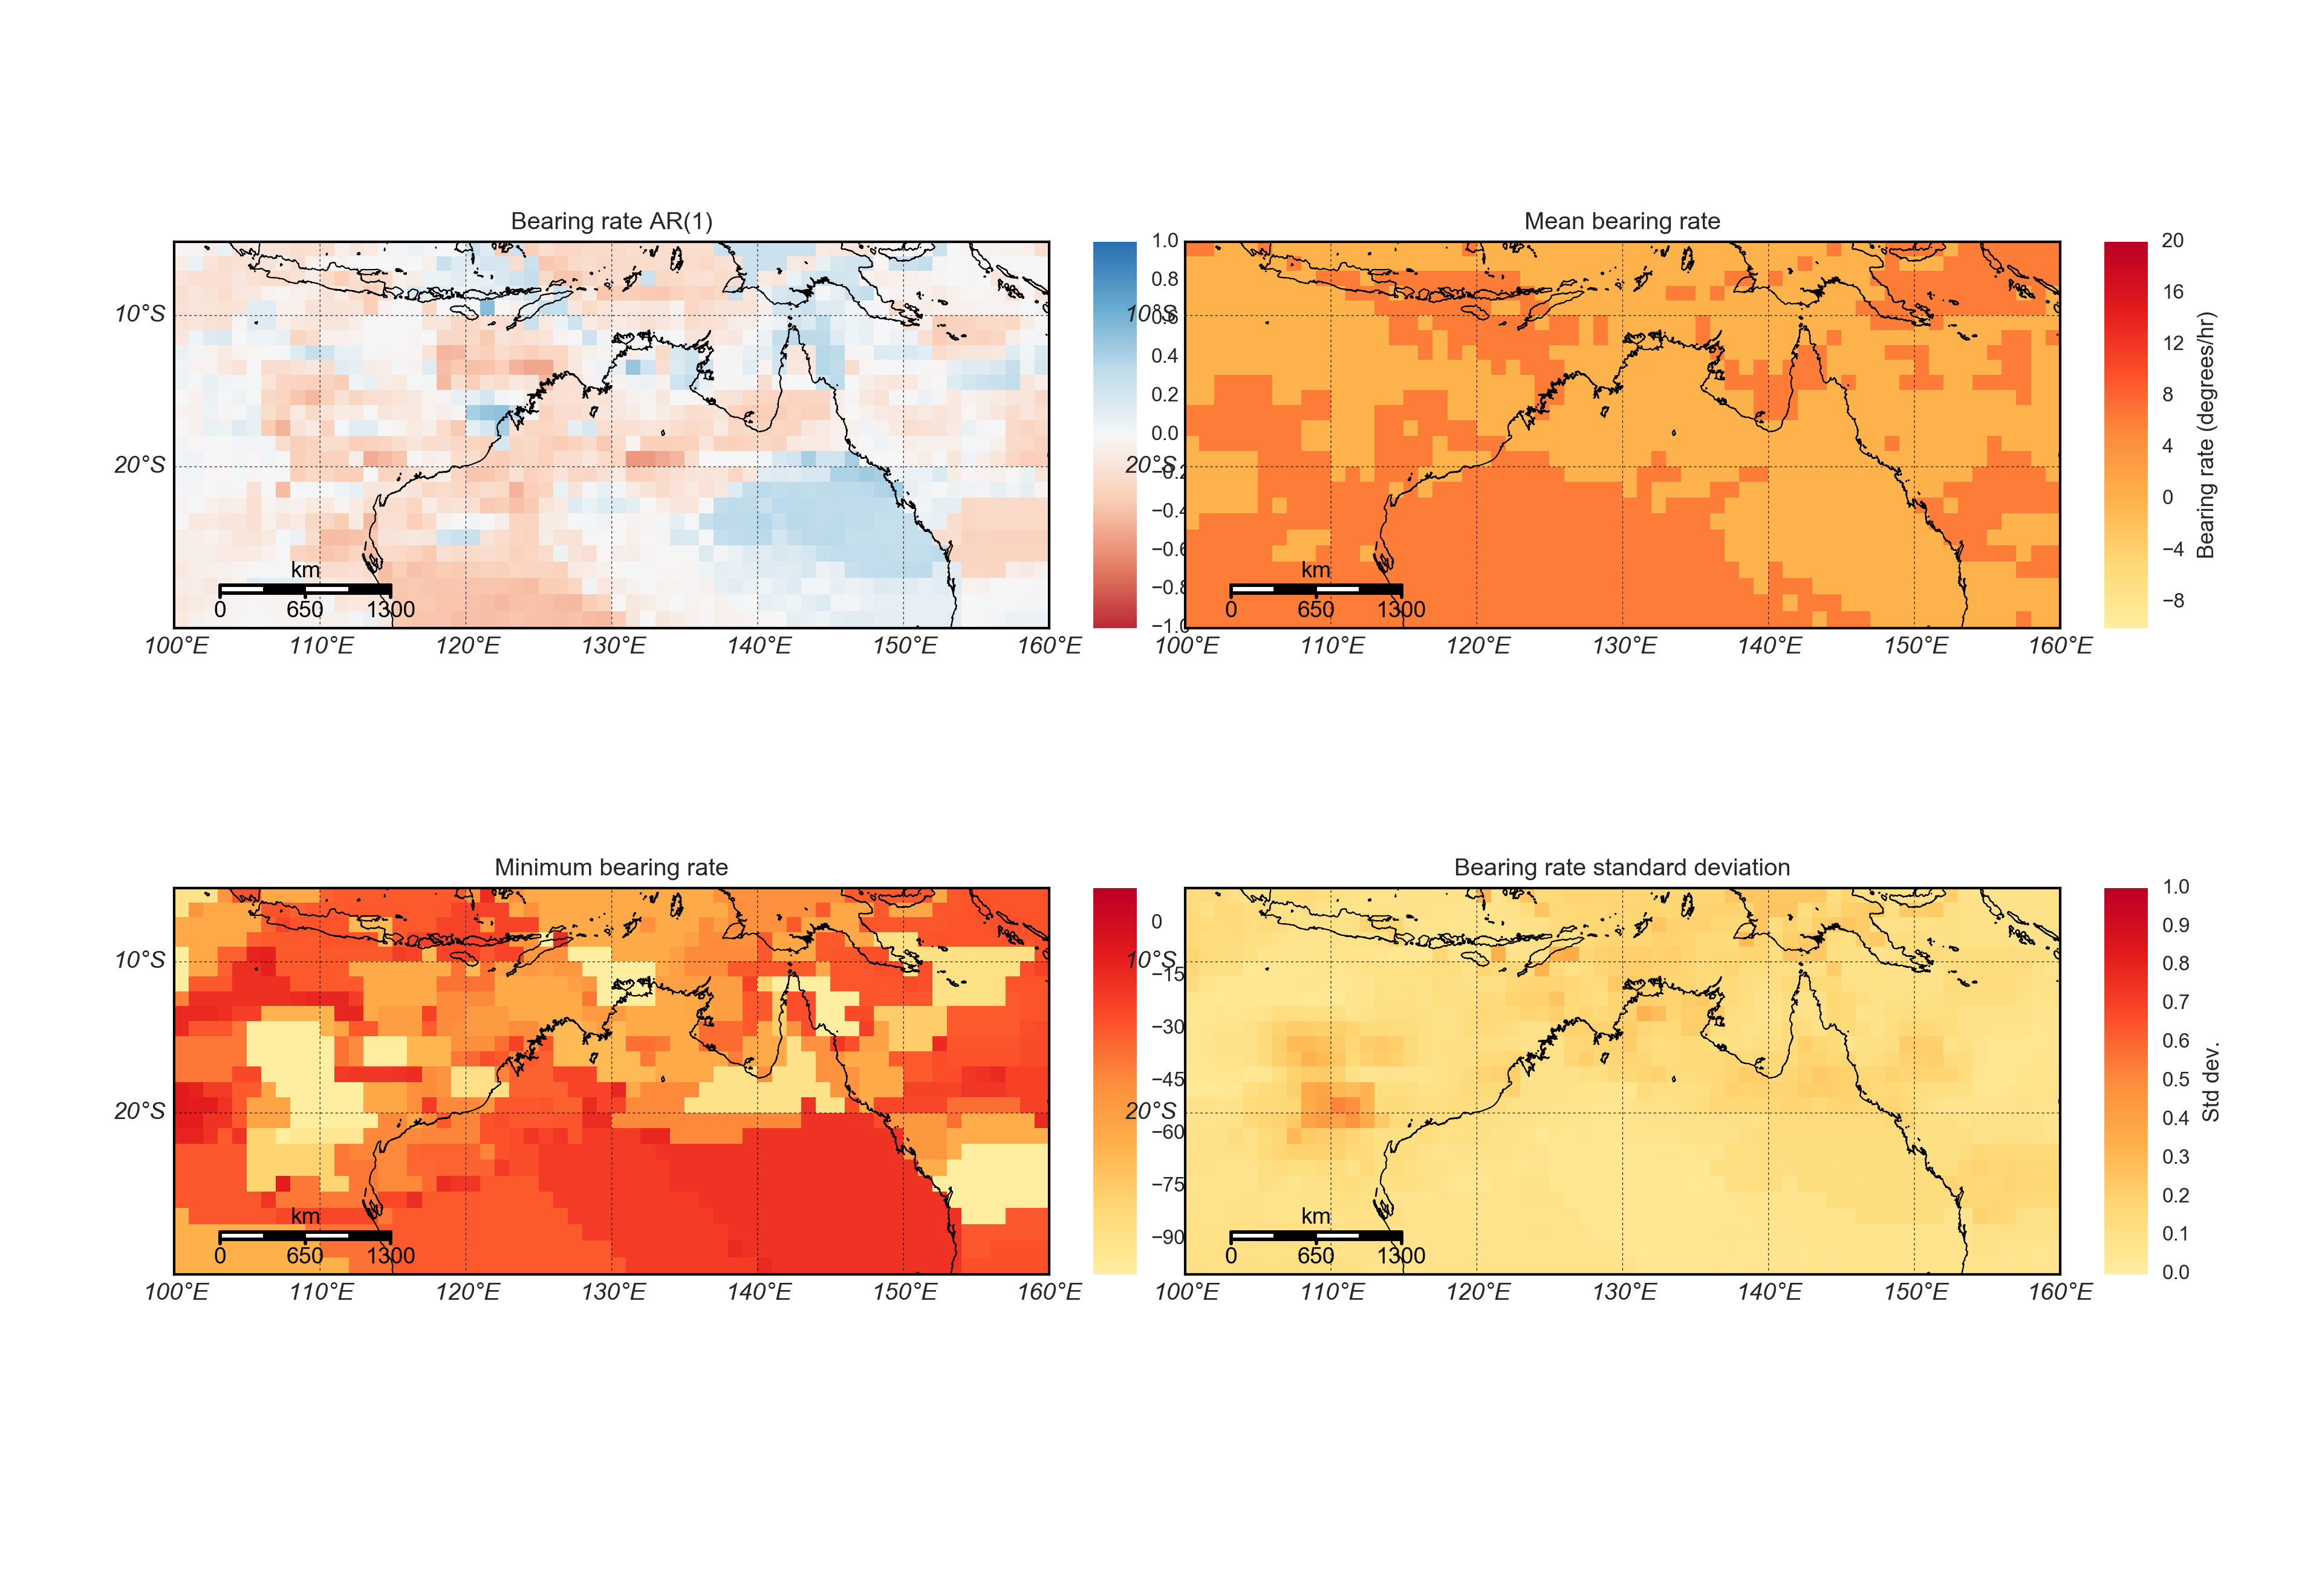

In [32]:
ncobj = ncLoadFile(pjoin(processPath, "bearing_rate_stats.nc"))
lon = ncGetDims(ncobj, 'lon')
lat = ncGetDims(ncobj, 'lat')
ardata = getData(ncobj, 'alpha', ij)
mudata = getData(ncobj, 'mu', ij)
mindata = getData(ncobj, 'min', ij)
sigdata = getData(ncobj, 'sig', ij)
ncobj.close()

fig = ArrayMapFigure()
fig.add(ardata, xgrid, ygrid, 'Bearing rate AR(1)', [-1, 1], 'AR(1)', map_kwargs)
fig.add(mudata, xgrid, ygrid, 'Mean bearing rate', [-10, 20], 'Bearing rate (degrees/hr)', map_kwargs)
fig.add(mindata, xgrid, ygrid, 'Minimum bearing rate', [-100., 10], 'Bearing rate (degrees/hr)', map_kwargs)
fig.add(sigdata, xgrid, ygrid, 'Bearing rate standard deviation', [0, 1], 'Std dev.', map_kwargs)
fig.plot()
#canvas = FC(fig)
#fig
saveFigure(fig, "bearing_rate_stats.png")
Image("bearing_rate_stats.png")

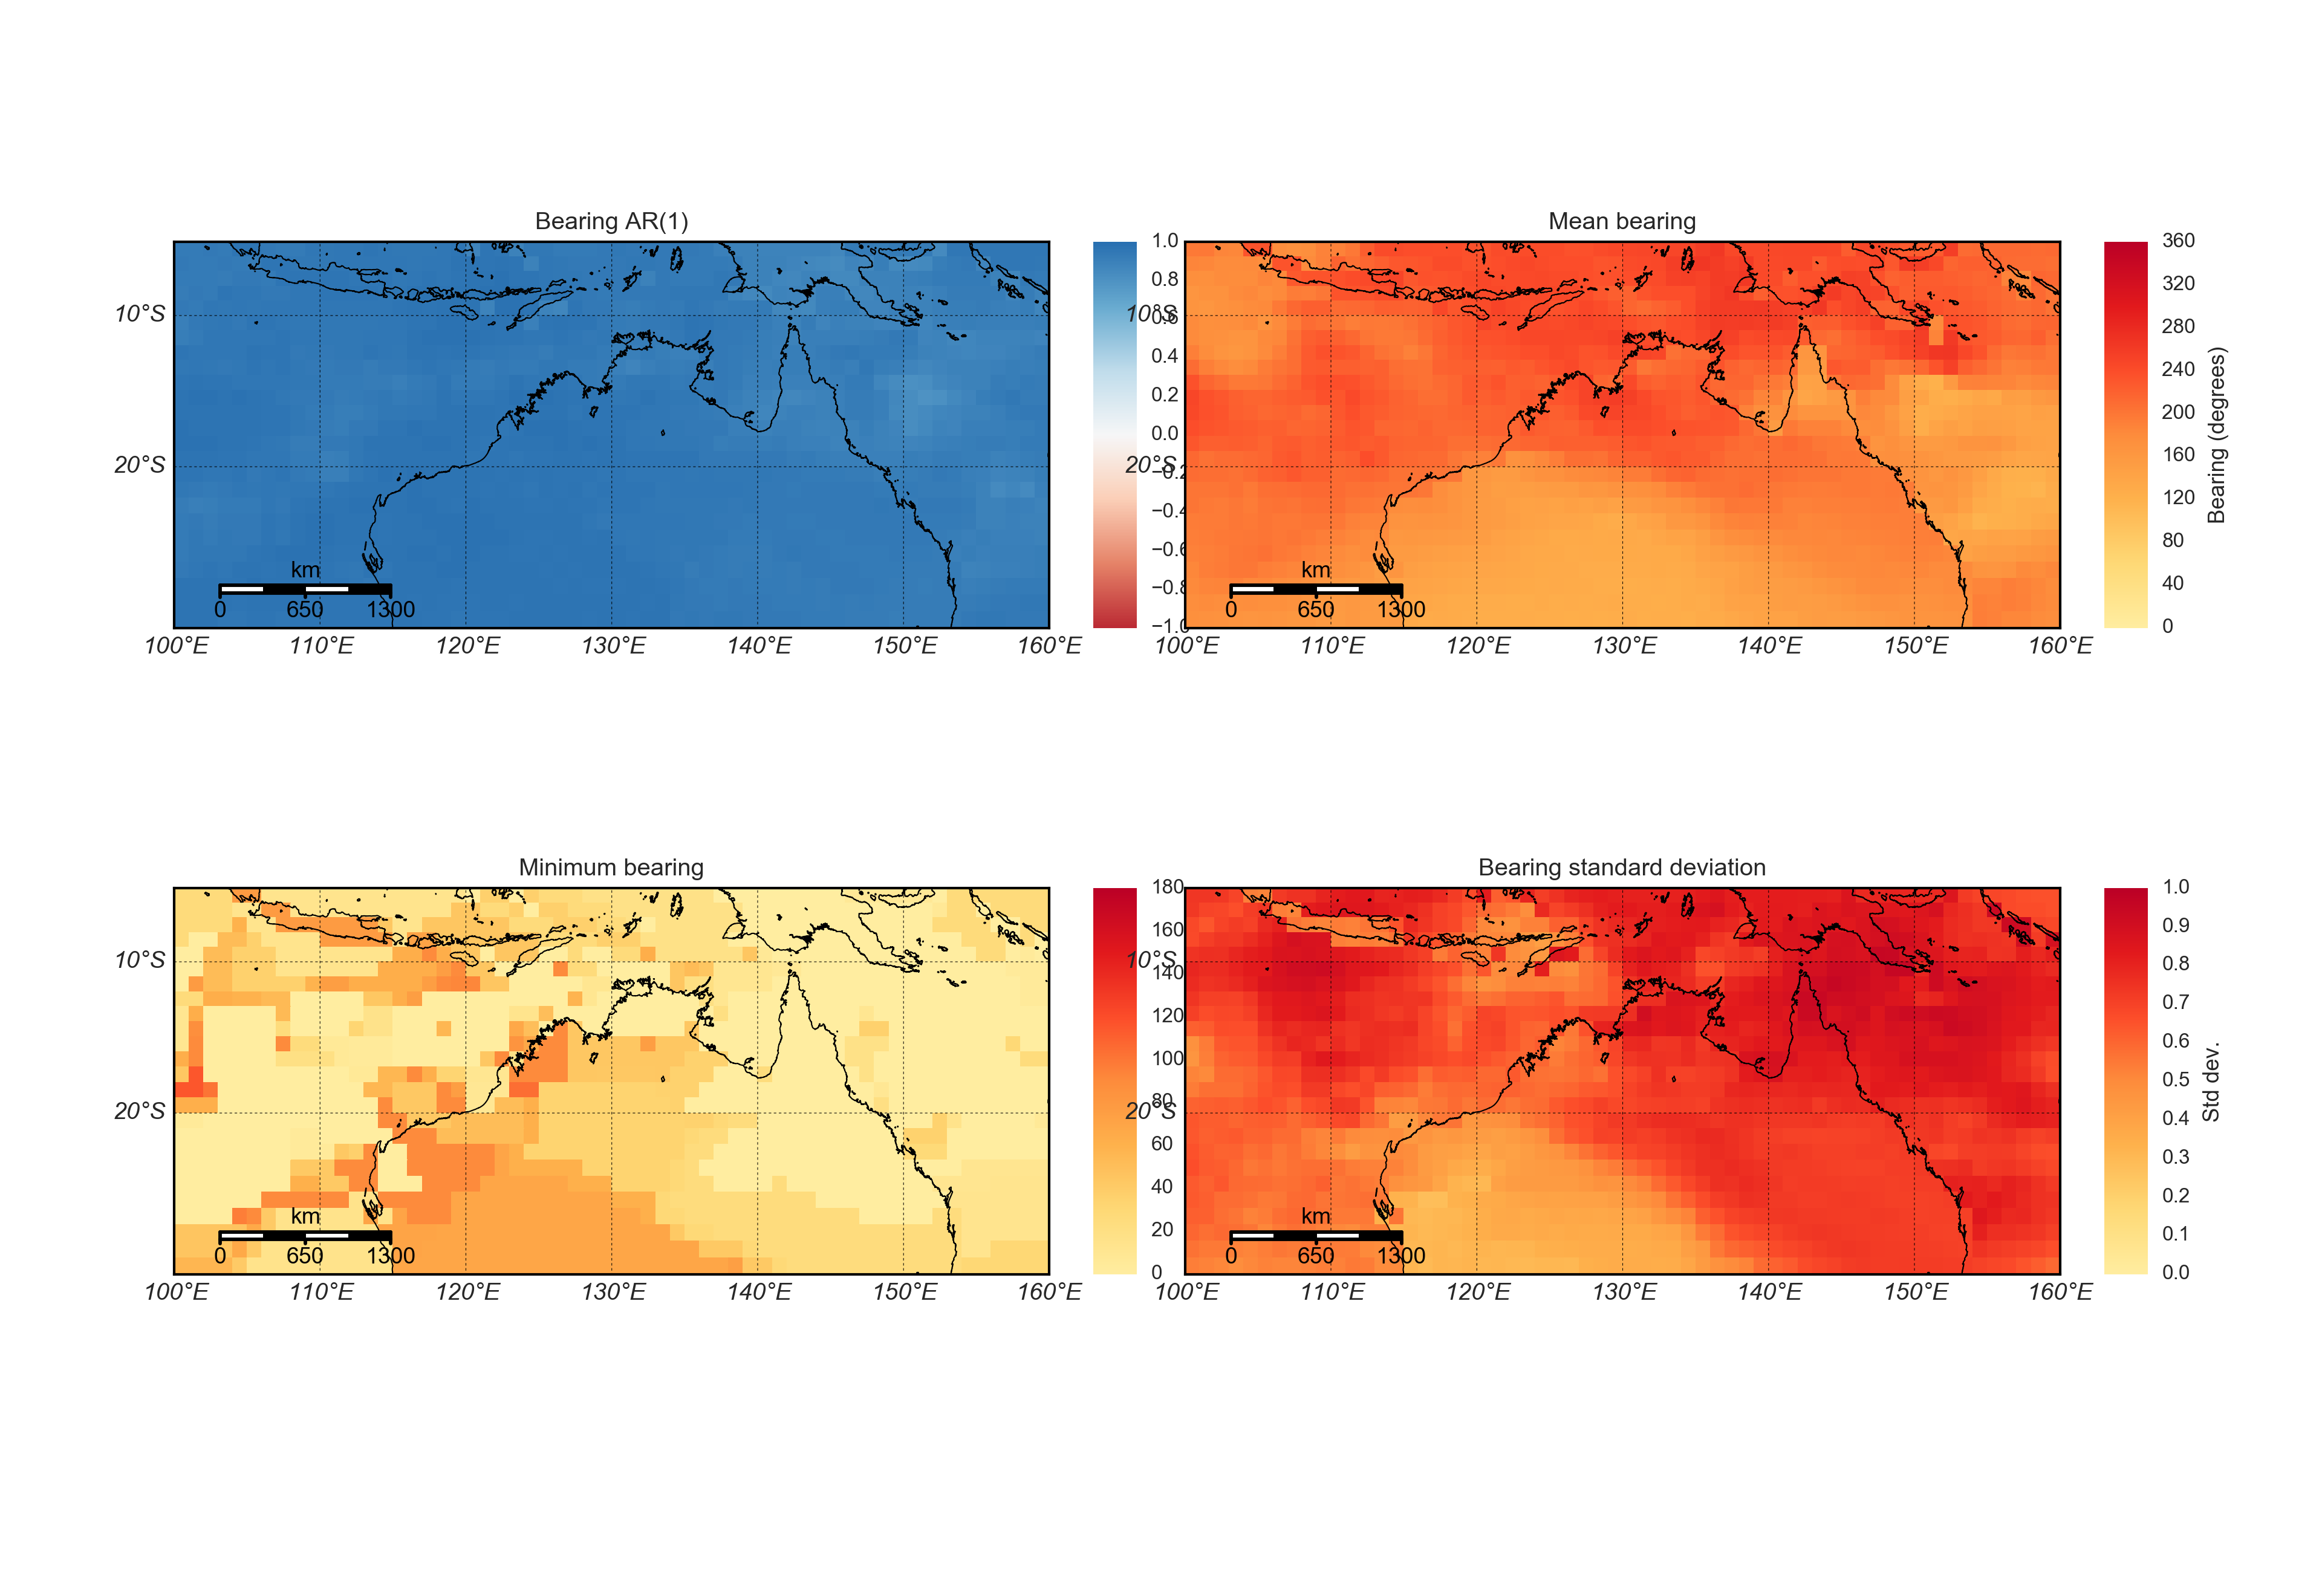

In [31]:
ncobj = ncLoadFile(pjoin(processPath, "bearing_stats.nc"))
lon = ncGetDims(ncobj, 'lon')
lat = ncGetDims(ncobj, 'lat')
ardata = getData(ncobj, 'alpha', ij)
mudata = getData(ncobj, 'mu', ij)
mindata = getData(ncobj, 'min', ij)
sigdata = getData(ncobj, 'sig', ij)

ncobj.close()
fig = ArrayMapFigure()
fig.add(ardata, xgrid, ygrid, 'Bearing AR(1)', [-1, 1], 'AR(1)', map_kwargs)
fig.add(mudata*180./np.pi, xgrid, ygrid, 'Mean bearing', [0, 360.], 'Bearing (degrees)', map_kwargs)
fig.add(mindata, xgrid, ygrid, 'Minimum bearing', [0, 180], 'Bearing (degrees)', map_kwargs)
fig.add(sigdata, xgrid, ygrid, 'Bearing standard deviation', [0, 1], 'Std dev.', map_kwargs)
fig.plot()
#canvas = FC(fig)
#fig
saveFigure(fig, "bearing_stats.png")
Image("bearing_stats.png")